## PHYS-253 

## Homework 4

Handed out: Monday, April 15, 2024

**Due: 4.59 pm; Monday, May 13, 2024**

__________________________________________________________________________________________________________________________

## Problem 1

Train a variational autoencoder (VAE) on an image dataset of your choice, and use it to generate images.


In order to avoid training many models, I went with the fashion mnist, which must be used in Problem 3.

In [4]:
import warnings
import tensorflow as tf
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
import matplotlib as mpl
from keras import backend as K

# Generating the dataset of my choice & normalizing it
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-6000], X_train_full[-6000:]
y_train, y_valid = y_train_full[:-6000], y_train_full[-6000:]

#Adding the necessary functions we saw in class:

def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))    
    
def show_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 2, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])
        
def show_images(images,n=5):
    plt.figure(figsize=(2*n,3))
    for i in range(n):
        plt.subplot(1, n, 1 + i)
        plot_image(images[i])
    plt.show()
        
def plot_images(im_train):
    n = len(im_train)
    rows = int(np.ceil(n/10))
    
    plt.figure(figsize=(13,2*rows))
    for i in range(n):
        plt.subplot(rows,10,1+i)
        plot_image(im_train[i])
    plt.show()
        
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean 



In [9]:
tf.random.set_seed(42)
np.random.seed(42)

codings_size = 10

inputs = keras.layers.Input(shape=[28, 28])
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(150, activation="selu")(z)
z = keras.layers.Dense(100, activation="selu")(z)
codings_mean = keras.layers.Dense(codings_size)(z)
codings_log_var = keras.layers.Dense(codings_size)(z)
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = keras.models.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

decoder_inputs = keras.layers.Input(shape=[codings_size])
x = keras.layers.Dense(100, activation="selu")(decoder_inputs)
x = keras.layers.Dense(150, activation="selu")(x)
x = keras.layers.Dense(28 * 28, activation="sigmoid")(x)
outputs = keras.layers.Reshape([28, 28])(x)
variational_decoder = keras.models.Model(inputs=[decoder_inputs], outputs=[outputs])

_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = keras.models.Model(inputs=[inputs], outputs=[reconstructions])

latent_loss = -0.5 * K.sum(
    1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),
    axis=-1)
variational_ae.add_loss(K.mean(latent_loss) / 784.)
variational_ae.compile(loss="binary_crossentropy", optimizer="adam", metrics=[rounded_accuracy]) 
history = variational_ae.fit(X_train, X_train, epochs=25, batch_size=128,
                             validation_data=(X_valid, X_valid))

loss, rounded_acc = variational_ae.evaluate(X_valid, X_valid)

print("Validation Loss:", loss)
print("Validation Rounded Accuracy:", rounded_acc)

Epoch 1/25
422/422 [==============================] - 3s 4ms/step - loss: 0.3707 - rounded_accuracy: 0.8766 - val_loss: 0.3393 - val_rounded_accuracy: 0.9053
Epoch 2/25
422/422 [==============================] - 2s 4ms/step - loss: 0.3312 - rounded_accuracy: 0.9085 - val_loss: 0.3290 - val_rounded_accuracy: 0.9110
Epoch 3/25
422/422 [==============================] - 2s 4ms/step - loss: 0.3241 - rounded_accuracy: 0.9134 - val_loss: 0.3242 - val_rounded_accuracy: 0.9151
Epoch 4/25
422/422 [==============================] - 2s 4ms/step - loss: 0.3200 - rounded_accuracy: 0.9161 - val_loss: 0.3210 - val_rounded_accuracy: 0.9176
Epoch 5/25
422/422 [==============================] - 2s 4ms/step - loss: 0.3174 - rounded_accuracy: 0.9180 - val_loss: 0.3188 - val_rounded_accuracy: 0.9187
Epoch 6/25
422/422 [==============================] - 2s 4ms/step - loss: 0.3158 - rounded_accuracy: 0.9191 - val_loss: 0.3172 - val_rounded_accuracy: 0.9199
Epoch 7/25
422/422 [==============================] 

1/1 [==============================] - 0s 88ms/step


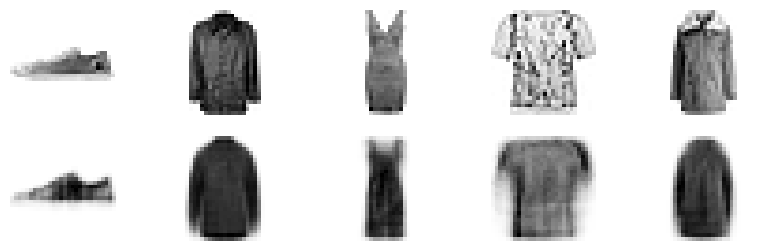

In [10]:
show_reconstructions(variational_ae)

## Problem 2

In this problem you will make changes to the image dataset of the previous problem and will train a VAE to generate images. You will generate images of your choice and you will compare the quality of the images.

a) Add Gaussian noise to the training dataset, train a VAE, generate images and compare their quality to the quality of the images generated in Problem 1. Try different levels of noise.

b) Instead of adding Gaussian noise to the training dataset, add dropout, train a VAE and generate images. How do they compare to the quality of the images generated in part a)? Try different levels of dropout.

c) Add Gaussian noise *and* dropout to the training dataset. Train a VAE generate images and compare their quality to the images generated in parts a) and b). Try different combinations of noise and dropout levels.

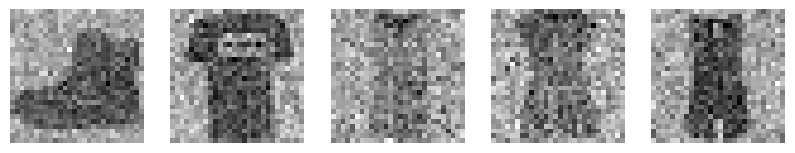

In [11]:
#Part a)

tf.random.set_seed(42)
np.random.seed(42)

noise = keras.layers.GaussianNoise(0.25)
X_train_noise = noise(X_train,training=True)
X_valid_noise = noise(X_valid,training=True)

show_images(X_train_noise)

In [12]:
K.clear_session()
history = variational_ae.fit(X_train_noise, X_train, epochs=50, batch_size=128,
                             validation_data=(X_valid_noise, X_valid))

Epoch 1/50
422/422 [==============================] - 2s 4ms/step - loss: 0.3148 - rounded_accuracy: 0.9197 - val_loss: 0.3160 - val_rounded_accuracy: 0.9202
Epoch 2/50
422/422 [==============================] - 2s 4ms/step - loss: 0.3125 - rounded_accuracy: 0.9215 - val_loss: 0.3153 - val_rounded_accuracy: 0.9210
Epoch 3/50
422/422 [==============================] - 2s 4ms/step - loss: 0.3120 - rounded_accuracy: 0.9219 - val_loss: 0.3153 - val_rounded_accuracy: 0.9209
Epoch 4/50
422/422 [==============================] - 2s 4ms/step - loss: 0.3116 - rounded_accuracy: 0.9223 - val_loss: 0.3148 - val_rounded_accuracy: 0.9211
Epoch 5/50
422/422 [==============================] - 2s 4ms/step - loss: 0.3113 - rounded_accuracy: 0.9224 - val_loss: 0.3146 - val_rounded_accuracy: 0.9218
Epoch 6/50
422/422 [==============================] - 2s 4ms/step - loss: 0.3111 - rounded_accuracy: 0.9227 - val_loss: 0.3146 - val_rounded_accuracy: 0.9220
Epoch 7/50
422/422 [==============================] 

1/1 [==============================] - 0s 36ms/step


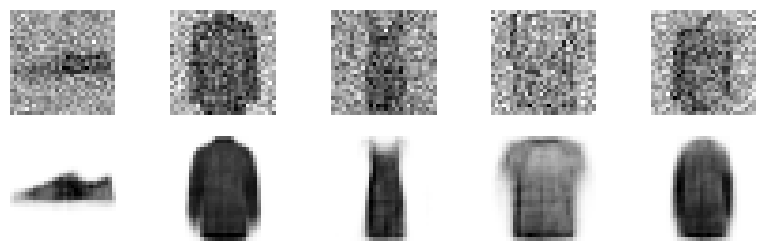

In [13]:
show_reconstructions(variational_ae,X_valid_noise)

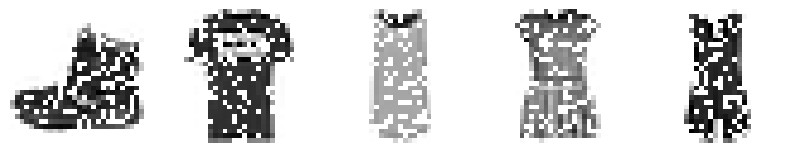

In [14]:
#Part B

tf.random.set_seed(42)
np.random.seed(42)

dropout = keras.layers.Dropout(0.25)
X_train_dropout = dropout(X_train,training=True)
X_valid_dropout = dropout(X_valid,training=True)

show_images(X_train_dropout)

In [15]:
K.clear_session()
history = variational_ae.fit(X_train_dropout, X_train, epochs=50, batch_size=128,
                             validation_data=(X_valid_dropout, X_valid))

Epoch 1/50
422/422 [==============================] - 2s 4ms/step - loss: 0.3091 - rounded_accuracy: 0.9238 - val_loss: 0.3117 - val_rounded_accuracy: 0.9236
Epoch 2/50
422/422 [==============================] - 2s 4ms/step - loss: 0.3085 - rounded_accuracy: 0.9240 - val_loss: 0.3111 - val_rounded_accuracy: 0.9232
Epoch 3/50
422/422 [==============================] - 2s 4ms/step - loss: 0.3082 - rounded_accuracy: 0.9242 - val_loss: 0.3116 - val_rounded_accuracy: 0.9229
Epoch 4/50
422/422 [==============================] - 2s 4ms/step - loss: 0.3079 - rounded_accuracy: 0.9244 - val_loss: 0.3110 - val_rounded_accuracy: 0.9231
Epoch 5/50
422/422 [==============================] - 2s 4ms/step - loss: 0.3078 - rounded_accuracy: 0.9244 - val_loss: 0.3110 - val_rounded_accuracy: 0.9233
Epoch 6/50
422/422 [==============================] - 2s 4ms/step - loss: 0.3076 - rounded_accuracy: 0.9245 - val_loss: 0.3106 - val_rounded_accuracy: 0.9232
Epoch 7/50
422/422 [==============================] 

1/1 [==============================] - 0s 34ms/step


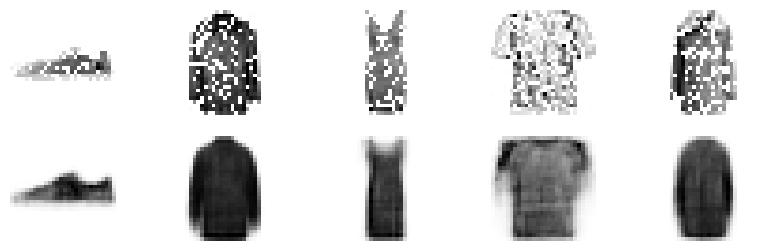

In [16]:
show_reconstructions(variational_ae,X_valid_dropout)

Should provide a comparison, either with pictures or just with text!!

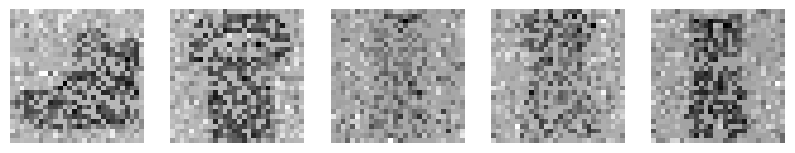

In [17]:
#Part C
tf.random.set_seed(42)
np.random.seed(42)

noise = keras.layers.GaussianNoise(0.25)
dropout = keras.layers.Dropout(0.35)
X_train_both = dropout(noise(X_train,training=True),training=True)
X_valid_both = dropout(noise(X_valid,training=True),training=True)

show_images(X_train_both)

In [20]:
K.clear_session()
history = variational_ae.fit(X_train_both, X_train, epochs=50, batch_size=128,
                             validation_data=(X_valid_both, X_valid))

Epoch 1/50
422/422 [==============================] - 2s 3ms/step - loss: 0.3089 - rounded_accuracy: 0.9227 - val_loss: 0.3174 - val_rounded_accuracy: 0.9179
Epoch 2/50
422/422 [==============================] - 1s 3ms/step - loss: 0.3088 - rounded_accuracy: 0.9227 - val_loss: 0.3170 - val_rounded_accuracy: 0.9178
Epoch 3/50
422/422 [==============================] - 1s 3ms/step - loss: 0.3088 - rounded_accuracy: 0.9227 - val_loss: 0.3171 - val_rounded_accuracy: 0.9183
Epoch 4/50
422/422 [==============================] - 1s 3ms/step - loss: 0.3087 - rounded_accuracy: 0.9229 - val_loss: 0.3174 - val_rounded_accuracy: 0.9176
Epoch 5/50
422/422 [==============================] - 1s 3ms/step - loss: 0.3087 - rounded_accuracy: 0.9228 - val_loss: 0.3174 - val_rounded_accuracy: 0.9185
Epoch 6/50
422/422 [==============================] - 1s 3ms/step - loss: 0.3088 - rounded_accuracy: 0.9227 - val_loss: 0.3174 - val_rounded_accuracy: 0.9178
Epoch 7/50
422/422 [==============================] 

1/1 [==============================] - 0s 31ms/step


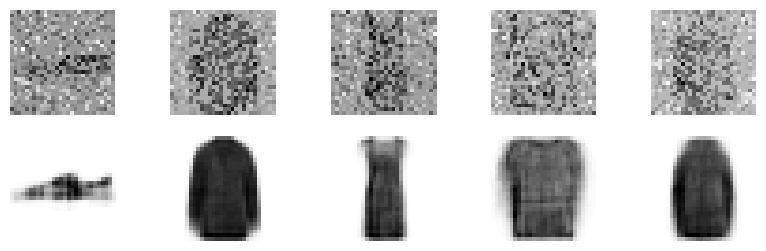

In [21]:
show_reconstructions(variational_ae,X_valid_both)

Observations!

## Problem 3: Morphing a fashion MNIST image
    
Train a VAE on the fashion MNIST dataset and morph a sweater to a shoe.

Present your morphing work as an animation.

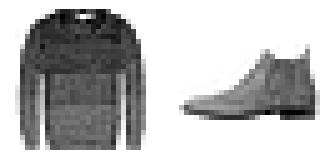

1/1 [==============================] - 0s 12ms/step


In [23]:
show_images([X_test[20],X_test[0]],2)

image_1 = X_test[20]
image_2 = X_test[0]

_, _, image_1 = variational_encoder.predict(tf.reshape(image_1,(1,28,28)))
_, _, image_2 = variational_encoder.predict(tf.reshape(image_2,(1,28,28)))


In [ ]:
import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')

def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0],cmap='binary')
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim# YOUR NAME: Emmanouil Smpokos ph5692

im_new = []
factors=np.linspace(0,1,101)
for factor in factors:
    im_new.append(image_1 * (1 - factor) + image_2 * factor)
    
images = []

for im in im_new:
    image = variational_decoder(im)
    image=tf.reshape(image,(28,28))     # we need to reshape to (28,28) [from (1,28,28)] to make the plot
    images.append(image)

In [26]:
plot_animation(images)

## Problem 4

This problem highligths the importance of KL divergence as a loss function. It is of particular importance to a conceptual understanding of Variational AutoEncoders (VAEs), which transform the discrete codings distribution (in latent space) of an AutoEncoder (AE) to the continuous distribution (in latent space, usually a multivariate normal distribution) from which new data (e.g. new images) can be sampled from. In VAEs, the KL divergence loss function is added to the reconstruction loss to produce new images resembling the original ones.

#### Your task:

1. Define s "target" normalized Gaussian distribution (denoted by blue color) and an "initial" normalized Gaussian distribution (red color) of your choice.

2. Write code to plot distributions (starting from the "initial" distribution) that continually minimize the KL divergence from the "target" distribution.  

3. Plot all distributions in a single plot.

HINT: the following schematics can serve as a guide.

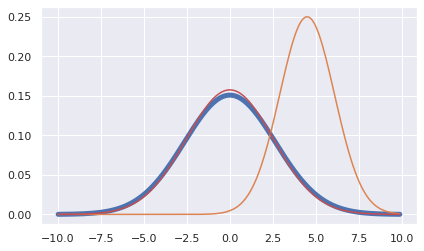

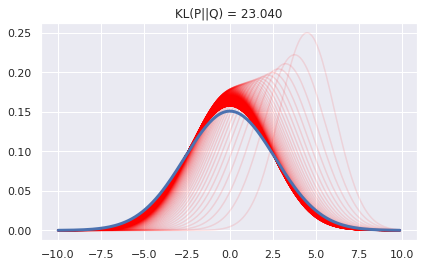

In [21]:
# Task 1
import numpy as np

def target_gaussian(x):
    mu = 0
    sigma = 1
    return 1 / np.sqrt(2 * np.pi * sigma**2) * np.exp(-0.5 * ((x - mu) / sigma)**2)

def initial_gaussian(x, mu, sigma):
    return 1 / np.sqrt(2 * np.pi * sigma**2) * np.exp(-0.5 * ((x - mu) / sigma)**2)

def kl_divergence(p, q):
    return np.sum(np.where(p != 0, p * np.log(p / q), 0))

Iteration 0, KL divergence: 87.1876
Iteration 100, KL divergence: 7.0102
Iteration 200, KL divergence: 0.0011
Converged at iteration 212


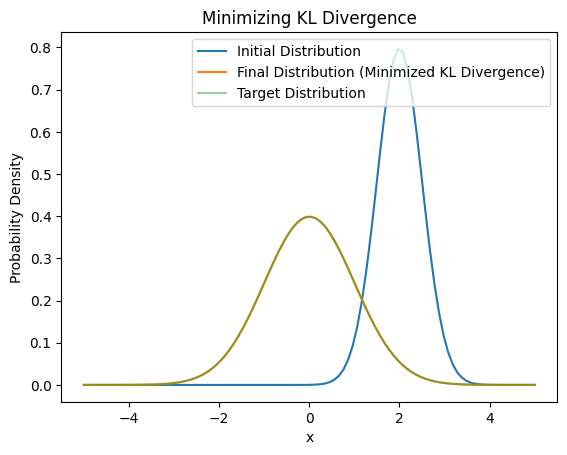

In [22]:
#Task2
# Gradient descent to minimize KL divergence

def minimize_kl_divergence(initial_mu, initial_sigma, target_func, lr=0.01, max_iterations=1000):
    mu = initial_mu
    sigma = initial_sigma
    
    for i in range(max_iterations):
        # Compute the initial distribution
        x = np.linspace(-5, 5, 100)
        initial_distribution = initial_gaussian(x, mu, sigma)
        
        # Compute KL divergence
        kl = kl_divergence(target_func(x), initial_distribution)
        
        # Compute gradient of KL divergence with respect to mu and sigma
        grad_mu = np.sum((initial_distribution - target_func(x)) * (x - mu) / sigma**2)
        grad_sigma = np.sum((initial_distribution - target_func(x)) * ((x - mu)**2 / sigma**3 - 1/sigma))
        
        # Update parameters
        mu -= lr * grad_mu
        sigma -= lr * grad_sigma
        
        # Print progress
        if i % 100 == 0:
            print("Iteration {}, KL divergence: {:.4f}".format(i, kl))
        
        # Check for convergence
        if abs(kl) < 1e-4:
            print("Converged at iteration", i)
            break
    
    return mu, sigma

# Set initial parameters
initial_mu = 2
initial_sigma = 0.5

# Perform gradient descent
final_mu, final_sigma = minimize_kl_divergence(initial_mu, initial_sigma, target_gaussian)

# Plot the initial and final distributions
x = np.linspace(-5, 5, 100)
plt.plot(x, initial_gaussian(x, initial_mu, initial_sigma), label='Initial Distribution')
plt.plot(x, initial_gaussian(x, final_mu, final_sigma), label='Final Distribution (Minimized KL Divergence)')
plt.plot(x, target_gaussian(x), label='Target Distribution', alpha = 0.5)
plt.legend()
plt.title('Minimizing KL Divergence')
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.show()

I have putted alpha = 0.5 so you can see that Final Distribution and Target Distribution are on top of each other, so perfectly converged!

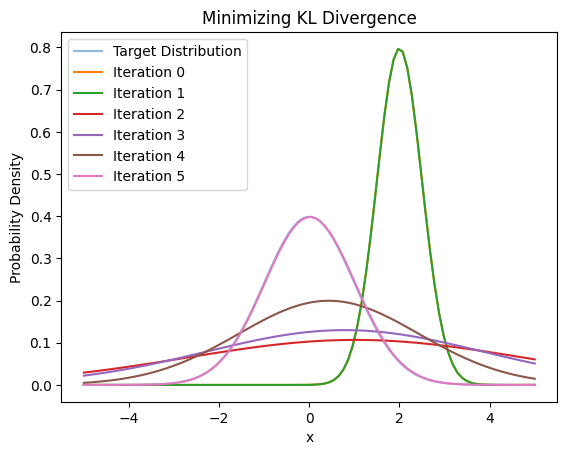

In [20]:
# Plot all distributions
x = np.linspace(-5, 5, 100)
plt.plot(x, target_gaussian(x), label='Target Distribution', alpha=0.5)
for i, distribution in enumerate(distributions):
    plt.plot(x, distribution, label=f'Iteration {i}')

plt.legend()
plt.title('Minimizing KL Divergence')
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.show()



- Hm something does not look good at all but could not find a solution even after trying with ChatGPT or googling.

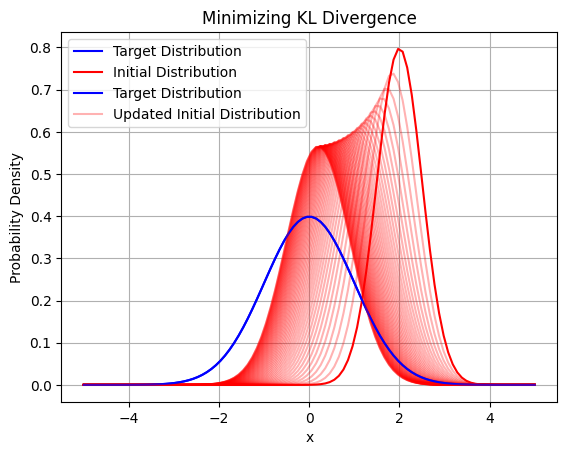

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

target_mu = 0
target_sigma = 1

target_pdf = norm.pdf(x, target_mu, target_sigma)
plt.plot(x, target_pdf, color='blue', label='Target Distribution')

initial_pdf = norm.pdf(x, initial_mu, initial_sigma)

# Plot the initial distribution
plt.plot(x, initial_pdf, color='red', label='Initial Distribution')

# Optimization loop
for i in range(50):
    # Calculate the KL divergence between the initial distribution and the target distribution
    kl_divergence = np.sum(target_pdf * np.log(target_pdf / initial_pdf))

    # Compute the gradient of the KL divergence
    dkl_dmean = (2 * (initial_mu - target_mu) / initial_sigma**2)
    dkl_dstd = ((initial_sigma**2 - target_sigma**2) / initial_sigma**3) + (1 / initial_sigma)

    initial_mu -= 0.01 * dkl_dmean
    initial_sigma -= 0.01 * dkl_dstd
    initial_pdf = norm.pdf(x, initial_mu, initial_sigma)

    # Plot the updated initial distribution
    plt.plot(x, initial_pdf, color='red', alpha=0.3)

plt.title('Minimizing KL Divergence')
plt.xlabel('x')
plt.ylabel('Probability Density')

plt.plot(x, target_pdf, color='blue', label='Target Distribution')
plt.plot(x, initial_pdf, color='red', alpha=0.3, label='Updated Initial Distribution')

plt.legend()
plt.grid(True)
plt.show()

Warning! Rerunning this last cell will change up the plot. In order to rerun it, the whole code for this exercise has to run again!

__________________________________________________________________________________________________________________________